In [2]:
import re
from PIL import Image
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils

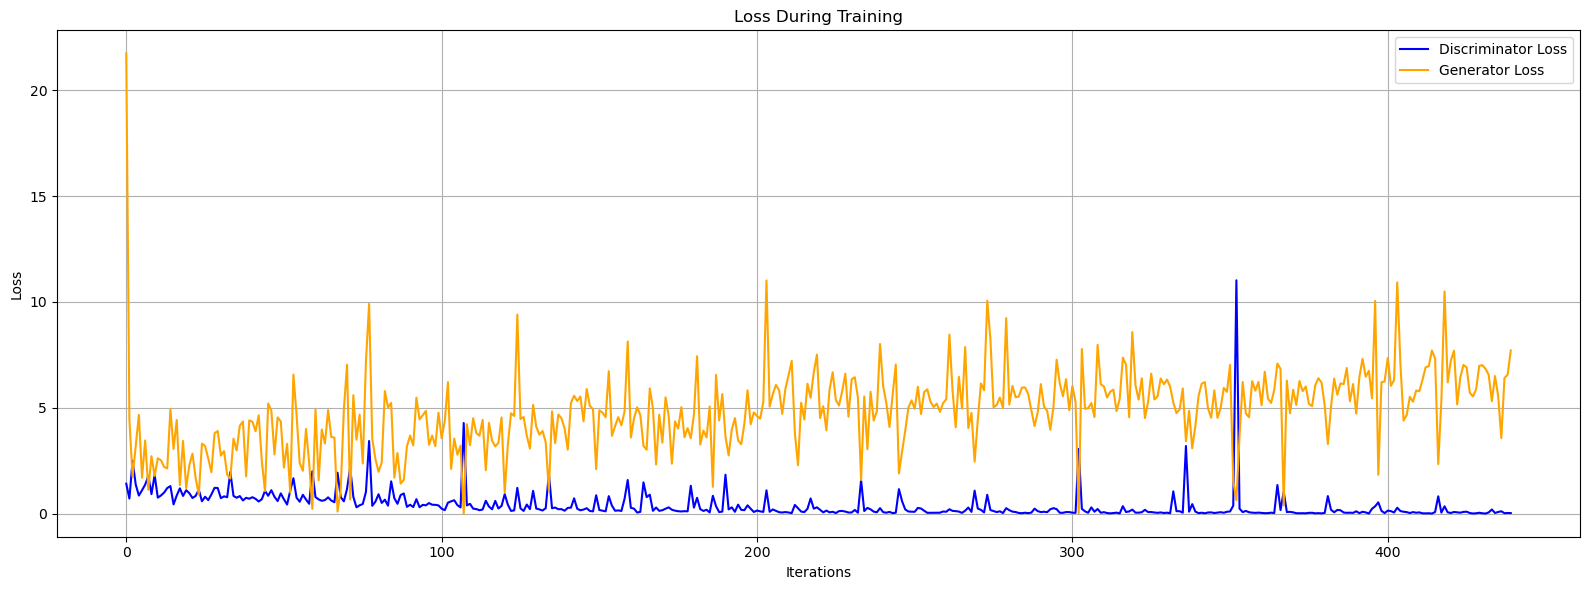

In [8]:
# Extracting data from the provided log
data = Path('gan_log.log').read_text()

# Parsing the log data
pattern = re.compile(r"\[.*\]\s*Loss_D:\s*([0-9.]+)\s*Loss_G:\s*([0-9.]+)")
matches = pattern.findall(data)

# Separating discriminator and generator losses
loss_d, loss_g = zip(*[(float(d), float(g)) for d, g in matches])


plt.figure(figsize=(16, 6))

plt.plot(loss_d, label='Discriminator Loss', color='blue')
plt.plot(loss_g, label='Generator Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('losses.png')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class MyImageFolder(Dataset):
    def __init__(self, folder_path, transforms):
        self.path = Path(folder_path)
        self.files = self.initialize_images(self.path)
        self.transforms = transforms
    
    def initialize_images(self, path):
        images = list(path.glob('*.jpg'))
        images = [str(x) for x in images]
        return images
    
    def __getitem__(self, ix):
        img = read_image(self.files[ix])
        img = img/255.
        img = self.transforms(img)
        return img
    
    def __len__(self):
        return len(self.files)

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64), antialias=True),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [5]:
train_dataset = MyImageFolder('/kaggle/input/the-car-connection-picture-dataset', train_transforms)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

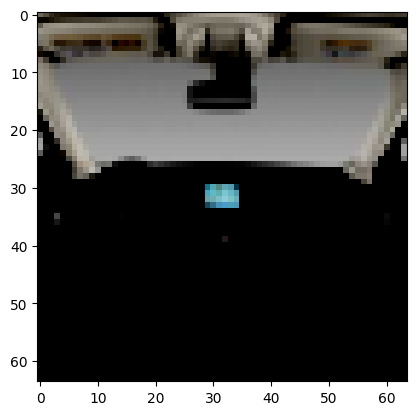

In [7]:
n = np.random.choice(len(train_dataset))
plt.imshow(train_dataset[n].numpy().transpose(1,2,0))

In [8]:
# custom weights initialization called on ``netG`` and ``netD``
## IS IT NECESSARY? -->> COMPARE WITH AND WITHOUT
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Size of z latent vector (i.e. size of generator input)
n_latent = 100

# Size of feature maps in generator
n_features = 64

In [10]:
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(n_latent, n_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_features * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(n_features * 8, n_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_features * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( n_features * 4, n_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_features * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(n_features * 2, n_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_features),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(n_features, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, x):
        return self.main(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, n_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(n_features, n_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(n_features * 2, n_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(n_features * 4, n_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(n_features * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.main(x)

In [12]:
generator = Generator().to(device)

generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [13]:
discriminator = Discriminator().to(device)

discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=500, gamma=0.6)
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=500, gamma=0.6)

In [15]:
# Training Loop
num_epochs = 40
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

In [16]:
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real = data.to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = F.sigmoid(output).mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = F.sigmoid(output).mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = F.sigmoid(output).mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/40][0/504]	Loss_D: 1.4235	Loss_G: 21.7346	D(x): 0.5445	D(G(z)): 0.4649 / 0.0000
[0/40][50/504]	Loss_D: 0.7239	Loss_G: 4.4299	D(x): 0.7350	D(G(z)): 0.1746 / 0.0573
[0/40][100/504]	Loss_D: 2.5059	Loss_G: 1.7542	D(x): 0.1764	D(G(z)): 0.0399 / 0.3106
[0/40][150/504]	Loss_D: 1.3871	Loss_G: 3.1852	D(x): 0.8408	D(G(z)): 0.6151 / 0.0968
[0/40][200/504]	Loss_D: 0.8650	Loss_G: 4.6728	D(x): 0.8466	D(G(z)): 0.4361 / 0.0314
[0/40][250/504]	Loss_D: 1.1160	Loss_G: 1.7034	D(x): 0.4419	D(G(z)): 0.0909 / 0.2244
[0/40][300/504]	Loss_D: 1.3818	Loss_G: 3.4657	D(x): 0.7932	D(G(z)): 0.5817 / 0.0633
[0/40][350/504]	Loss_D: 1.7885	Loss_G: 1.1430	D(x): 0.2798	D(G(z)): 0.0805 / 0.3801
[0/40][400/504]	Loss_D: 0.9337	Loss_G: 2.7226	D(x): 0.6271	D(G(z)): 0.2633 / 0.1101
[0/40][450/504]	Loss_D: 1.8368	Loss_G: 1.7918	D(x): 0.3135	D(G(z)): 0.0595 / 0.2626
[0/40][500/504]	Loss_D: 0.7669	Loss_G: 2.6241	D(x): 0.6497	D(G(z)): 0.1607 / 0.1073
[1/40][0/504]	Loss_D: 0.8685	Loss_G: 2.5299	D(x): 0.

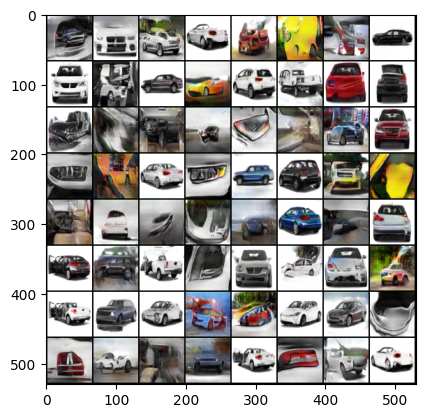

In [17]:
plt.imshow(img_list[-1].cpu().numpy().transpose(1,2,0))

In [18]:
torch.save(generator.state_dict(), 'generator.pth')

In [19]:
torch.save(discriminator.state_dict(), 'discriminator.pth')